# Validation


## Imports / Setup


In [1]:
import boto3
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from ladybug.epw import EPW
from lightning.pytorch import Trainer
import torch
import numpy as np

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from utils.constants import JOULES_TO_KWH
from weather.weather import extract

from archetypal import settings

if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

from archetypal.idfclass import IDF

Couldn't import dot_parser, loading of dot files will not be possible.


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Config Vars


In [2]:
bucket = "ml-for-bem"
s3 = boto3.client("s3")

local_dir = Path("data") / "temp"
experiment_name = "validation/v2/seattle"
should_gather_idf = False

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## Helper Fns


In [20]:
# list objects in bucket using paginator
def get_files_in_experiment(experiment):
    print("Listing files for experiment: ", experiment, "...")
    files = []
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=experiment):
        if page.get("Contents"):
            for obj in page["Contents"]:
                files.append(obj["Key"])
    return files


def download(file):
    filepath = local_dir / file
    os.makedirs(filepath.parent, exist_ok=True)
    s3.download_file(bucket, file, filepath)
    return filepath


def download_and_open_json(file):
    filepath = download(file)
    with open(filepath, "r") as f:
        return json.load(f)


def download_and_open_hdf(file):
    filepath = download(file)
    return pd.read_hdf(filepath)


def get_weather():
    weather_folder = (Path(experiment_name).parent / "epw").as_posix()
    # list files in weather folder
    weather_files = get_files_in_experiment(weather_folder)
    with ThreadPoolExecutor(max_workers=8) as executor:
        weather_files = list(
            tqdm(executor.map(download, weather_files), total=len(weather_files))
        )
    return weather_files


def download_and_open_ground_truth():
    file = experiment_name + "/Buildings.hdf"
    true_df = download_and_open_hdf(file)

    true_df = true_df.sort_index(level="file_name")
    building_id = (
        true_df.index.to_frame()["file_name"].str.split(".").str[0].astype(int)
    )
    building_id.name = "building_id"
    true_df = true_df.set_index(building_id, append=True).sort_index(
        level="building_id"
    )

    true_df = true_df * JOULES_TO_KWH
    return true_df

## Gather/Download Validation Files


In [4]:
if should_gather_idf:
    idf_files = get_files_in_experiment(experiment_name + "/idf")
    idf_files = idf_files[:100]
    with ThreadPoolExecutor(max_workers=8) as executor:
        idf_files = list(tqdm(executor.map(download, idf_files), total=len(idf_files)))

features_fp = Path(experiment_name).parent / "features.hdf"
features_fp = download(features_fp.as_posix())
features = pd.read_hdf(features_fp, key="shoeboxes")
building_meta = pd.read_hdf(features_fp, key="buildings")

## Check for errors in hdf etc


In [5]:
def test_idf(building_id):
    idf_path = (
        Path("data")
        / "temp"
        / Path(experiment_name).parent
        / "idf"
        / f"{building_id:09d}.idf"
    ).as_posix()
    idf = IDF(idf_path)
    zones = idf.idfobjects["ZONE"]
    # remove final _<number> from zone names
    zone_names = ["_".join(zone.Name.split("_")[:-1]) for zone in zones]
    zones_by_name = {zone_name: zone for zone_name, zone in zip(zone_names, zones)}

    area = 0
    for zone in zones_by_name.values():
        area += zone.Floor_Area

    assert abs(building_meta.loc[building_id, "gfa"] - area) < 1
    areas = (
        features.groupby(level="building_id")
        .sum()
        .loc[building_id, ["core_area", "zone_perimeter_area"]]
    )
    assert np.abs(areas["core_area"] / 4 + areas["zone_perimeter_area"] - area) < 1e-1


for building_id in tqdm(building_meta.index.to_list()[:10]):
    test_idf(building_id)

  0%|          | 0/10 [00:00<?, ?it/s]

## Allocate Shoebox dimensions

Floor-to-floor height and shoebox width are fixed.


In [6]:
# sb_perim_facade_area = features.width * features.height
# sb_perim_area = features.zone_perim_floor_area_to_facade_area * sb_perim_facade_area
# sb_perim_depth = sb_perim_area / features.width
# sb_core_depth = features.zone_core_area_to_perimeter_area * sb_perim_depth

features["perim_depth"] = features.building_computed_perim_depth
features["core_depth"] = features.building_computed_core_depth

## Load Weather, Schedules


In [7]:
city = "seattle"
weather_files = get_weather()
epw_path = next(filter(lambda x: city.lower() in str(x).lower(), weather_files))
print(epw_path)
epw = EPW(epw_path)
climate = extract(epw)
scheds = np.load("data/schedules.npy")

Listing files for experiment:  validation/v2/epw ...


  0%|          | 0/3 [00:00<?, ?it/s]

data\temp\validation\v2\epw\USA_WA_Seattle-Tacoma.Intl.AP.727930_TMYx.2007-2021.epw


## Load Surrogate and Predict


In [8]:
surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()
torch.set_float32_matmul_precision("medium")

trainer = Trainer(
    accelerator="auto",
    devices="auto",
    strategy="auto",
    enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
ml_shoebox_results, ml_monthly, ml_annual = predict_ubem(
    trainer=trainer,
    surrogate=surrogate,
    features=features.reset_index(),
    schedules=scheds,
    climate=climate,
    apply_cops=False,
    batch_size=64,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3440/3440 [01:54<00:00, 30.00it/s]


## Compute Electricity


In [51]:
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cols = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

pred_elec = pd.DataFrame(columns=cols, index=[])
for ix, row in tqdm(list(building_meta.iterrows()), total=len(building_meta)):
    template_ix = int(row["template_idx"])
    e_sched = scheds[template_ix, 0]
    l_sched = scheds[template_ix, 1]
    lpd = row["LightingPowerDensity"]  # measured in Watts/m2
    epd = row["EquipmentPowerDensity"]  # measured in Watts/m2
    e_timestep = epd * e_sched / 1000  # kWh
    l_timestep = lpd * l_sched / 1000  # kWh
    total = e_timestep + l_timestep
    # split total into months, each timestep is one hour
    hours_passed = 0
    month_totals = []
    for month in month_lengths:
        month_total = total[hours_passed : hours_passed + month * 24]
        hours_passed += month * 24
        month_totals.append(month_total.sum())
    pred_elec.loc[ix] = month_totals

  0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
es = pd.read_csv("data/EquipmentAvailabilitySchedule.csv")
es = es[es.columns[1:]]

## Load Ground Truth


In [49]:
true_results = download_and_open_ground_truth()
if len(true_results) != len(building_meta):
    print("WARNING: Not all buildings have ground truth results!!")
true_results_ids = true_results.index.get_level_values("building_id")

true_results = true_results / building_meta.loc[true_results_ids, "gfa"].values.reshape(
    -1, 1
)

In [63]:
scheds[14].sum()

0.0

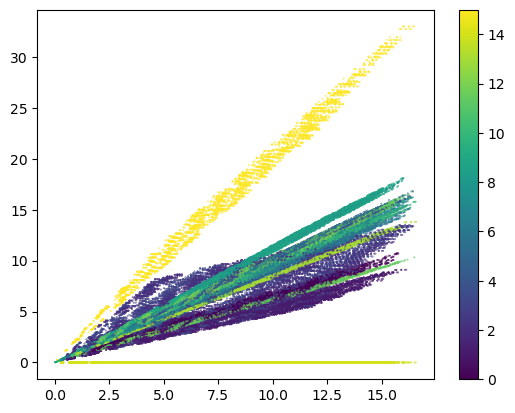

In [55]:
template_indices = (
    building_meta.loc[true_results_ids, "template_idx"]
    .astype(float)
    .values.reshape(-1, 1)
    .repeat(12, axis=1)
    .flatten()
)
pred_elec_res = pred_elec.loc[true_results_ids].values.flatten()
plt.scatter(
    true_results["Electricity:Facility"].values.flatten(),
    pred_elec_res,
    # alpha=0.1,
    s=0.1,
    c=template_indices,
)
plt.colorbar()

In [60]:
building_meta.iloc[3].template_idx

14.0

In [62]:
es

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,...,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
1,0.10,0.10,0.10,0.10,0.10,0.10,0.25,0.35,0.35,0.25,...,0.25,0.25,0.35,0.35,0.35,0.25,0.25,0.25,0.25,0.25
2,0.10,0.10,0.10,0.10,0.10,0.10,0.25,0.35,0.35,0.25,...,0.25,0.25,0.35,0.35,0.35,0.25,0.25,0.25,0.25,0.25
3,0.10,0.10,0.10,0.10,0.10,0.10,0.35,0.35,0.25,0.25,...,0.25,0.25,0.25,0.35,0.35,0.35,0.25,0.25,0.25,0.25
4,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.30,0.30,...,0.90,0.90,0.90,0.90,0.80,0.80,0.70,0.40,0.20,0.20
5,0.15,0.15,0.15,0.15,0.15,0.15,0.30,0.30,0.30,0.30,...,0.80,0.80,0.80,0.60,0.40,0.40,0.40,0.40,0.15,0.15
6,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,...,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30
7,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,...,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30
8,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.50,0.50,...,1.00,1.00,1.00,1.00,0.50,0.50,0.30,0.30,0.30,0.30
9,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.50,0.50,...,0.50,0.50,0.50,0.30,0.30,0.30,0.30,0.30,0.30,0.30


In [61]:
scheds[14, 0, : 24 * 7]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [57]:
# true_results["Electricity:Facility"]

In [58]:
# elec_error = np.abs(
#     true_results["Electricity:Facility"].values - pred_elec.loc[true_results_ids].values
# )
# elec_error

## Plotting


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ml_ax = ax[0, 0]
idf_ax = ax[0, 1]
scatter_h_ax = ax[1, 0]
scatter_c_ax = ax[1, 1]


ml_ax.plot(ml_monthly.Heating.values.T, color="red", alpha=0.2)


ml_ax.plot(ml_monthly.Cooling.values.T, color="blue", alpha=0.2)
idf_ax.plot(true_results["Heating:DistrictHeating"].values.T, color="red", alpha=0.2)
idf_ax.plot(true_results["Cooling:DistrictCooling"].values.T, color="blue", alpha=0.2)
ml_ax.set_ylim(0, 100)
idf_ax.set_ylim(0, 100)
ml_ax.set_title("ML")
idf_ax.set_title("IDF")
scatter_h_ax.set_title("Heating Model Fit")
scatter_h_ax.set_xlabel("IDF")
scatter_h_ax.set_ylabel("ML")
scatter_c_ax.set_title("Cooling Model Fit")
scatter_c_ax.set_xlabel("IDF")
scatter_c_ax.set_ylabel("ML")
scatter_h_ax.scatter(
    true_results["Heating:DistrictHeating"].values.flatten(),
    ml_monthly.Heating.values.flatten().clip(0, 1000),
    color="red",
    alpha=0.2,
)
scatter_c_ax.scatter(
    true_results["Cooling:DistrictCooling"].values.flatten(),
    ml_monthly.Cooling.values.flatten().clip(0, 1000),
    color="blue",
    alpha=0.2,
)
# plot identity line on top of scatter
x = np.linspace(0, np.max(ml_monthly.Cooling.values.flatten()), 100)
scatter_c_ax.plot(x, x, color="black", linestyle="--")
x = np.linspace(0, np.max(ml_monthly.Heating.values.flatten()), 100)
scatter_h_ax.plot(x, x, color="black", linestyle="--")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Annual Model Fits")
h_ax = ax[0]
c_ax = ax[1]
h_ax.set_title("Heating")
c_ax.set_title("Cooling")

h_ax.scatter(
    true_results["Heating:DistrictHeating"].sum(axis=1),
    ml_annual.Heating,
    color="red",
    alpha=0.2,
)
h_ax.set_ylim(0, 50)
h_ax.set_xlim(0, 50)

c_ax.scatter(
    true_results["Cooling:DistrictCooling"].sum(axis=1),
    ml_annual.Cooling,
    color="blue",
    alpha=0.2,
)
c_ax.set_ylim(0, 50)
c_ax.set_xlim(0, 50)